In [1]:
import xlwings as xw
import wget
import os
from datetime import datetime
from datetime import timedelta
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np

## Partie 1 : Acquisition et chargement des données 

On télécharge les fichiers de classement, et on supprime les skippers qui a abandonné la course dans chaque période.

In [2]:
# pour éviter l'erreur [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired

import ssl
import urllib

ssl._create_default_https_context = ssl._create_unverified_context


In [3]:
begin_date = datetime(2020,11,9)
end_date = datetime(2021,1,26)
hour = ['04','08','11','14','17','21']
hour_begin = ['14','15','17','21']
out_path = r'C:/Users/17760/Kit-Big-Data-master/projet final/data'

In [4]:
def dateTostr(date):
    str_date = date.strftime('%Y%m%d')
    return str_date                          

In [5]:
date_list = []
date = begin_date
while date <= end_date:  
    str_d = dateTostr(date)
    date_list.append(str_d)
    date = date + timedelta(days=1)

In [6]:
if not os.listdir(out_path):
    for d in date_list:
        for h in hour:
            url = f'https://www.vendeeglobe.org/download-race-data/vendeeglobe_{d}_{h}0000.xlsx'
            wget.download(url,out=out_path)
    for h in hour_begin:
        url = f'https://www.vendeeglobe.org/download-race-data/vendeeglobe_20201108_{h}0000.xlsx'
        wget.download(url,out=out_path)
else:
    print(f"Les fichiers Excel sont déjà téléchargées dans local")


Les fichiers Excel sont déjà téléchargées dans local


In [7]:
def prepareData(date,hour):
    
    url = f"data/vendeeglobe_{date}_{hour}0000.xlsx"
    
    with xw.Book(url, mode="r") as book:
        sheet1 = book.sheets[0]
        df = sheet1.cells.options('df').value
        df.iloc[3,:3] = df.iloc[2,:3]
        df.iloc[3,-2:] = df.iloc[2,-2:]
        df = df.iloc[3:-4]
        
        df.iloc[0,0]=df.iloc[0,0].replace('\r\nRank','')
        df.iloc[0] = df.iloc[0].str.split('\r\n').str[0]
        df.iloc[0,6:10] = df.iloc[0,6:10]+"_since30min"
        df.iloc[0,10:14] = df.iloc[0,10:14]+"_lastReport"
        df.iloc[0,14:18] = df.iloc[0,14:18]+"_since24h"
        df.columns = df.iloc[0]
        df = df.iloc[1:]
        
        df['Nationalité'] = df.iloc[:,1].str.split(' ').str[0]
        df['Nationalité'] = df.iloc[:,-1].str.split('\r\n').str[-1]
        df['Voile'] = df.iloc[:,1].str.split(' ').str[1]
        df['Skipper'] = df.iloc[:,2].str.split('\r\n').str[0]
        df['Bateau'] = df.iloc[:,2].str.split('\r\n').str[1]
        df = df.drop(['Nat. / Voile', 'Skipper / Bateau'], axis=1)
        day = datetime.strptime(date, '%Y%m%d')
        df['Date'] = day
        df = df.reset_index(drop=True)
        
        return df
        

In [8]:
data_final = pd.DataFrame()
for h in hour_begin:
        data = prepareData('20201108',h)
        data = data.dropna()
        data_final = pd.concat([data_final,data],axis=0)
for d in date_list:
    for h in hour:
        data = prepareData(d,h)
        data = data.dropna()
        data_final = pd.concat([data_final,data],axis=0)
data_final.reset_index(drop=True)
data_final.head()

,Rang,Heure FR,Latitude,Longitude,Cap_since30min,Vitesse_since30min,VMG_since30min,Distance_since30min,Cap_lastReport,Vitesse_lastReport,...,Vitesse_since24h,VMG_since24h,Distance_since24h,DTF,DTL,Nationalité,Voile,Skipper,Bateau,Date
0,1,15:30 FR\r\n,46°24.46'N,01°50.48'W,241°,17.7 kts,17.5 kts,0.3 nm,357°,0.0 kts,...,0.3 kts,0.3 kts,6.1 nm,24293.9 nm,0.0 nm,FRA,18,Louis Burton,Bureau Vallée 2,2020-11-08
1,2,15:31 FR\r\n1min,46°24.34'N,01°49.82'W,241°,11.1 kts,10.9 kts,0.4 nm,357°,0.0 kts,...,0.3 kts,0.2 kts,6.0 nm,24294.2 nm,0.4 nm,MON,10,Boris Herrmann,Seaexplorer - Yacht Club De Monaco,2020-11-08
2,3,15:30 FR\r\n,46°24.91'N,01°49.99'W,244°,15.5 kts,15.5 kts,0.5 nm,357°,0.0 kts,...,0.2 kts,0.2 kts,5.5 nm,24294.3 nm,0.5 nm,FRA,8,Jérémie Beyou,Charal,2020-11-08
3,4,15:30 FR\r\n,46°24.71'N,01°49.68'W,244°,13.2 kts,13.1 kts,0.7 nm,357°,0.0 kts,...,0.2 kts,0.2 kts,5.6 nm,24294.5 nm,0.6 nm,FRA,59,Thomas Ruyant,LinkedOut,2020-11-08
4,5,15:30 FR\r\n,46°24.59'N,01°49.56'W,246°,10.9 kts,10.9 kts,0.2 nm,357°,0.0 kts,...,0.8 kts,0.7 kts,5.8 nm,24294.5 nm,0.6 nm,FRA,53,Maxime Sorel,V And B Mayenne,2020-11-08


In [9]:
data_final.isnull().sum()

Rang                   0
Heure FR               0
Latitude               0
Longitude              0
Cap_since30min         0
Vitesse_since30min     0
VMG_since30min         0
Distance_since30min    0
Cap_lastReport         0
Vitesse_lastReport     0
VMG_lastReport         0
Distance_lastReport    0
Cap_since24h           0
Vitesse_since24h       0
VMG_since24h           0
Distance_since24h      0
DTF                    0
DTL                    0
Nationalité            0
Voile                  0
Skipper                0
Bateau                 0
Date                   0
dtype: int64

In [10]:
print(f'Le tableau final de classement contient {data_final.shape[0]} lignes et {data_final.shape[1]} colonnes.')

Le tableau final de classement contient 13603 lignes et 23 colonnes.


Ensuite,on acquiert les fichiers de caractéristiques de bateau, on le transforme dans un DataFrame en indiquant le nom du bateau et le nom de skipper.

In [11]:
url = "https://www.vendeeglobe.org/fr/glossaire"
soup = BeautifulSoup(requests.get(url).content)

In [12]:
# trouver le nom des bateaux et des skipper
boat_list = soup.find_all('h3', {"class","boats-list__boat-name"})
boat_name = []
skipper = []
for boat in boat_list:
    name_boat = boat.text
    boat_name.append(name_boat)
    name_skipper = boat.parent()[1].text
    skipper.append(name_skipper)

In [13]:
boat_car = soup.find_all('ul', {"class","boats-list__popup-specs-list"})
dic_boat_final = []
for boat in boat_car:
    dic_boat = {}
    li_tag = boat.find_all('li')
    for tag in li_tag :
        dic_boat[tag.text.split(':')[0]] = tag.text.split(':')[1]
    dic_boat_final.append(dic_boat)
df_boat = pd.DataFrame(dic_boat_final)

boat_name = pd.DataFrame(boat_name,columns=['Nom du bateau'])
skipper = pd.DataFrame(skipper,columns = ['Skipper'])
carac_bateau = pd.concat([boat_name,skipper,df_boat],axis=1)

carac_bateau.head()

,Nom du bateau,Skipper,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,NEWREST - ART & FENÊTRES,Fabrice AMEDEO,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,"18,28 m","5,85 m","4,50 m",7 t,foils,29 m,monotype,320 m2,570 m2
1,PURE - Best Western®,Romain ATTANASIO,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,"18,28m","5,80m","4,50m",9t,2,28m,acier forgé,280 m2,560 m2
2,TSE - 4MYPLANET,Alexia BARRIER,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeu...",Marc Lombard,MAG France,01 Mars 1998,"18,28m","5,54m","4,50m",9t,2,29 m,acier,260 m2,580 m2
3,Maître CoQ IV,Yannick BESTAVEN,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,"18,28 m","5,80 m","4,50 m",8 t,foils,29 m,acier mécano soudé,310 m2,550 m2
4,CHARAL,Jérémie BEYOU,08,NaN,VPLP,CDK Technologies,18 Août 2018,"18,28 m","5,85 m","4,50 m",8t,foils,29 m,acier,320 m2,600 m2


In [14]:
carac_bateau.isnull().sum(axis=1)

0      0
1      0
2      0
3      0
4      1
5      0
6      0
7      0
8      0
9      0
10     1
11     0
12     0
13     0
14     1
15     0
16    13
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     2
27     0
28     1
29     1
30     0
31     1
32     1
33     2
dtype: int64

Vu que pour le skipper 'François Guiffant', on a presque aucune information sur son bateau, donc il ne sert pas à faire l'analyse, par conséquence, on le supprime de la liste.

In [15]:
carac_bateau = carac_bateau.drop(16, axis=0)
carac_bateau = carac_bateau.reset_index(drop=True)

In [16]:
print(f'Le tableau final de caratéristique de bateau contient {carac_bateau.shape[0]} bateaux, avec {carac_bateau.shape[1]} colonnes')

Le tableau final de caratéristique de bateau contient 33 bateaux, avec 16 colonnes


## Partie 2 : Préparation des données

Extraction des caractéristiques techniques de chacun des voiliers.

In [17]:
n = [7,8,9,10,12,14,15,11]
tech_boat = carac_bateau.iloc[:,n].copy()
pd.options.mode.chained_assignment = None  # default='warn'

In [18]:
tech_boat = tech_boat.stack().str.replace(',','.').unstack()

In [19]:
tech_boat.iloc[14,3]=None
tech_boat.iloc[24,3]=None

In [51]:
c_num = ['Longueur ', 'Largeur ', 'Tirant d\'eau ', 
       'Hauteur mât ','Surface de voiles au près ', 'Surface de voiles au portant ']
for c in c_num:
    tech_boat[c] = [float(v[0]) for v in tech_boat[c].str.split('m')]
    
list1 = tech_boat['Déplacement (poids) '].str.split('t')
for i in range(len(tech_boat)):
    if tech_boat['Déplacement (poids) '][i]:
        tech_boat['Déplacement (poids) '][i] = float(list1[i][0])
    else:
        pass

AttributeError: Can only use .str accessor with string values!

In [21]:
tech_boat

,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Hauteur mât,Surface de voiles au près,Surface de voiles au portant,Nombre de dérives
0,18.28,5.85,4.5,7.0,29.0,320.0,570.0,foils
1,18.28,5.80,4.5,9.0,28.0,280.0,560.0,2
2,18.28,5.54,4.5,9.0,29.0,260.0,580.0,2
3,18.28,5.80,4.5,8.0,29.0,310.0,550.0,foils
4,18.28,5.85,4.5,8.0,29.0,320.0,600.0,foils
5,18.28,5.65,4.5,7.9,29.0,300.0,610.0,foils
6,18.28,5.80,4.5,7.6,28.0,300.0,600.0,foils
7,18.28,5.30,4.5,8.9,26.0,240.0,470.0,2
8,18.28,5.80,4.5,9.0,28.5,270.0,560.0,2 asymétriques
9,18.28,5.70,4.5,7.7,29.0,340.0,570.0,2


Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers

In [135]:
vmg = data_final.loc[:,['Skipper','Rang','VMG_lastReport']]

In [136]:
vmg['Rang'] = vmg['Rang'].astype('int')
#vmg['VMG_since30min'] = [float(a[0]) for a in vmg['VMG_since30min'].str.split(' ')]
vmg['VMG_lastReport'] = [float(a[0]) for a in vmg['VMG_lastReport'].str.split(' ')]

In [137]:
df = vmg.groupby('Skipper').mean()
df

,Rang,VMG_lastReport
Skipper,,
Alan Roura,16.343096,11.080335
Alex Thomson,7.461538,11.120513
Alexia Barrier,25.148536,9.497490
Ari Huusela,26.401674,9.361297
Armel Tripon,16.395397,12.244979
Arnaud Boissieres,17.909474,11.128842
Benjamin Dutreux,7.533473,12.429498
Boris Herrmann,6.974895,12.782845
Charlie Dalin,2.297694,12.740461


In [138]:
x = df.iloc[:,-1:]
y = df.iloc[:,0]

In [139]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

data = LinearRegression().fit(x_train,y_train)

In [144]:
y_pred = data.predict(x_test)

In [141]:
data.score(x_test,y_test)

0.7415213030736365

In [ ]:
#for col in boats_useful_cols:
    #df_skippers_with_boats[col] = df_skippers_with_boats['skipper_id'].apply(lambda x: df_boats_characteristics[df_boats_characteristics['skipper_id']==x][col].value

Text(0.5, 1.0, 'Corrélation et régression linéaire entre le rang et la VMG')

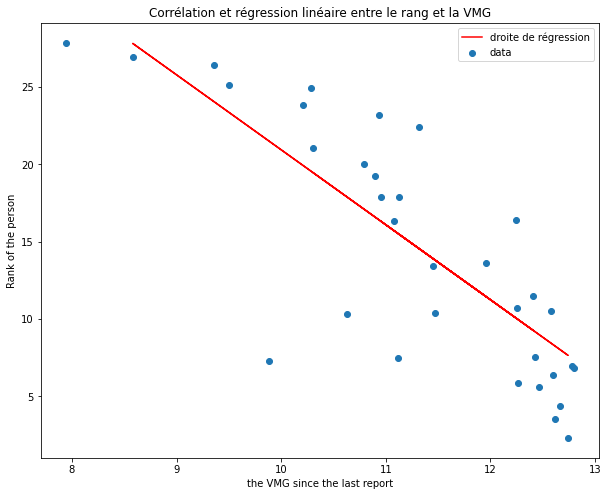

In [146]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.scatter(x,y,label='data')
plt.xlabel('the VMG since the last report')
plt.ylabel('Rank of the person')

plt.plot(x_test,y_pred,'r',label='droite de régression')
    
plt.legend()
plt.title('Corrélation et régression linéaire entre le rang et la VMG')